<a href="https://colab.research.google.com/github/mrcasutt/lightinthedark/blob/master/light_the_dark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from fastai import *
from radam import *
from fastai.vision import *
from fastai.callbacks import *
import pandas as pd
import numpy as np
import matplotlib as plt
from imutils import paths
import argparse
import requests
import cv2
import os
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
from fastai.utils.mem import *
from torchvision.models import vgg16_bn

In [0]:
shutil.rmtree('./train')

In [0]:
folder = 'full_size'
path = Path('./train')
dest = path/folder
fnpath = Path('./')
fnnames = './urls.csv'
dest.mkdir(parents=True, exist_ok=True)
classes = ['train']

In [0]:
#Javascript to add in browser console:
#urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
#window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [0]:
download_images(fnpath/fnnames, dest, max_pics = 1000)

In [0]:
verify_images(dest, delete=True, max_size=2000)

In [0]:
path_orig = Path('./train/full_size')
path_hr = Path('./train/high_res')
path_mr = Path('./train/med_res')
path_lr = Path('./train/low_res')
il = ImageList.from_folder(path_orig)


In [0]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_orig)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(0.2)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
    img.save(dest, quality=q)

In [0]:
# create smaller image sets the first time this nb is run
sets = [(path_lr,96),(path_mr,256),(path_hr,1200)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [0]:
bs,size = 32,96
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)


In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_orig/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
size = 1200
data_hr = (ImageImageList.from_folder(path_hr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(max_zoom=2),size = size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_hr.c = 3

In [0]:
data = get_data(bs,size)

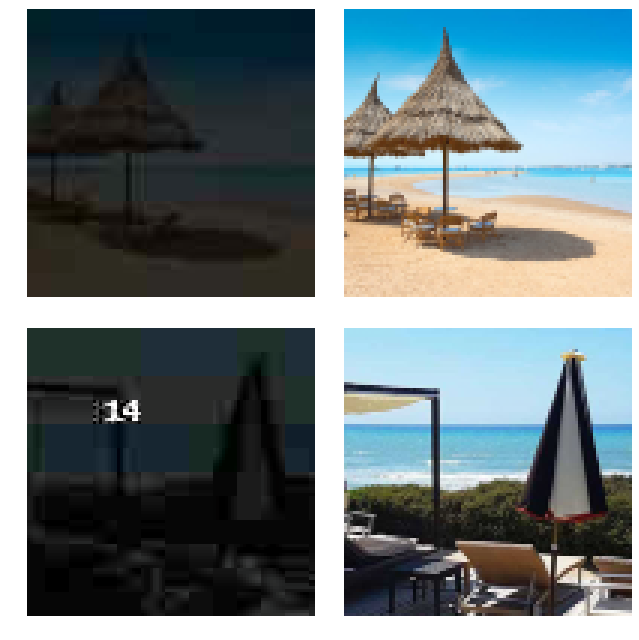

In [28]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [30]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

gram_matrix(t)

base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])
raoptar = partial(RAdam)
wd = 1e-3
lr = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight,opt_func=raoptar)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


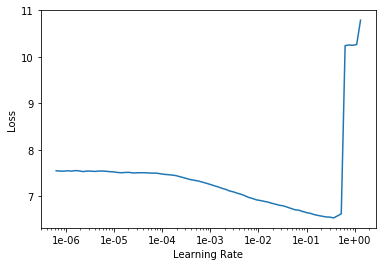

In [33]:
learn.lr_find()
learn.recorder.plot()

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=3, imgsize=3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,7.497098,7.182433,1.162368,0.394550,0.533772,0.248641,1.657546,2.724513,0.461043,00:32
1,7.307804,7.026617,1.165356,0.393202,0.527679,0.229982,1.628346,2.674752,0.407300,00:29
2,7.024685,6.681506,1.048154,0.394468,0.524732,0.216604,1.550405,2.566328,0.380816,00:28
3,6.715411,6.259936,0.962265,0.381677,0.509970,0.209125,1.436061,2.385139,0.375699,00:28
4,6.411510,5.948345,0.892930,0.367620,0.495839,0.199579,1.370639,2.259865,0.361873,00:28
5,6.127510,5.648034,0.769201,0.370128,0.484070,0.190891,1.305573,2.178605,0.349567,00:28
6,5.884357,5.331532,0.668940,0.357230,0.476114,0.184495,1.212573,2.085319,0.346862,00:28
7,5.661929,5.143713,0.587213,0.352053,0.469065,0.180261,1.169576,2.039217,0.346329,00:28
8,5.450797,4.946075,0.555850,0.346330,0.462081,0.177286,1.085345,1.975744,0.343439,00:28
9,5.255776,4.807187,0.520050,0.342028,0.456252,0.174535,1.047599,1.927119,0.339605,00:29


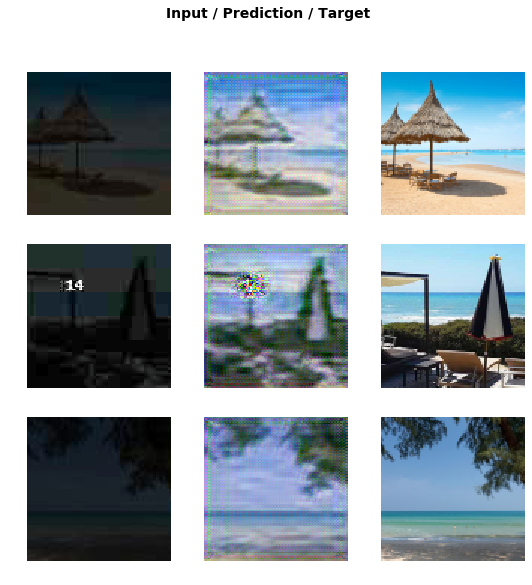

In [35]:
do_fit('1a', slice(1e-3,1e-1))

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


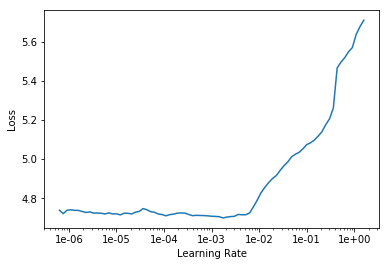

In [38]:
learn.lr_find()
learn.recorder.plot()

In [0]:
do_fit('1b', slice(1e-6,1e-3))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


In [0]:
size = 256
bs = 16
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
learn.data = data_mr

In [0]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [0]:

learn.freeze()
gc.collect()

18142

In [0]:
learn.load('1b');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.499149,3.427863,0.495402,0.338310,0.371869,0.122339,0.805886,1.105984,0.188073,01:14
1,3.459122,3.380065,0.499430,0.337015,0.371161,0.121197,0.793628,1.070361,0.187272,00:51
2,3.419415,3.335081,0.487383,0.336667,0.370947,0.120253,0.785539,1.047862,0.186429,00:50
3,3.384526,3.296577,0.495422,0.335022,0.370846,0.119334,0.767695,1.022518,0.185740,00:52
4,3.357115,3.277883,0.519281,0.332956,0.368501,0.117975,0.753321,1.001065,0.184783,00:51
5,3.301161,3.207824,0.481210,0.331499,0.367027,0.117079,0.740117,0.986562,0.184330,00:51
6,3.272887,3.187442,0.482906,0.330220,0.367289,0.116926,0.727322,0.978711,0.184067,00:51
7,3.249324,3.141617,0.467361,0.329800,0.365648,0.115746,0.714167,0.965582,0.183313,00:52
8,3.214059,3.104405,0.461783,0.328497,0.364527,0.115512,0.701898,0.948876,0.183312,00:51
9,3.197329,3.088450,0.446613,0.328608,0.364252,0.115150,0.703028,0.947568,0.183230,00:52


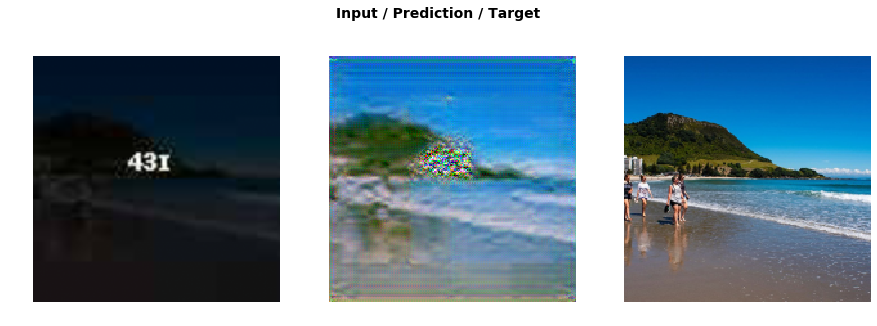

In [0]:
do_fit('2a')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.164860,3.086200,0.446804,0.328476,0.363210,0.114719,0.704535,0.945404,0.183052,00:52
1,3.161519,3.086368,0.454682,0.328486,0.363283,0.114670,0.699778,0.942503,0.182966,00:52
2,3.140948,3.083369,0.454294,0.328260,0.362827,0.114559,0.699674,0.940740,0.183016,00:52
3,3.128593,3.076509,0.444729,0.328549,0.363132,0.114834,0.698638,0.943533,0.183095,00:52
4,3.136957,3.078990,0.451919,0.328380,0.362582,0.114582,0.697888,0.940694,0.182944,00:52
5,3.143684,3.075986,0.451303,0.328531,0.362602,0.114516,0.696683,0.939448,0.182903,00:52
6,3.146117,3.071258,0.449631,0.328259,0.362194,0.114494,0.696315,0.937461,0.182905,00:52
7,3.148553,3.072084,0.447545,0.328241,0.362615,0.114645,0.696244,0.939855,0.182940,00:52
8,3.138149,3.072206,0.443853,0.328747,0.362948,0.114799,0.696476,0.942383,0.183000,00:53
9,3.127428,3.073846,0.447575,0.328206,0.362463,0.114543,0.697916,0.940166,0.182977,00:53


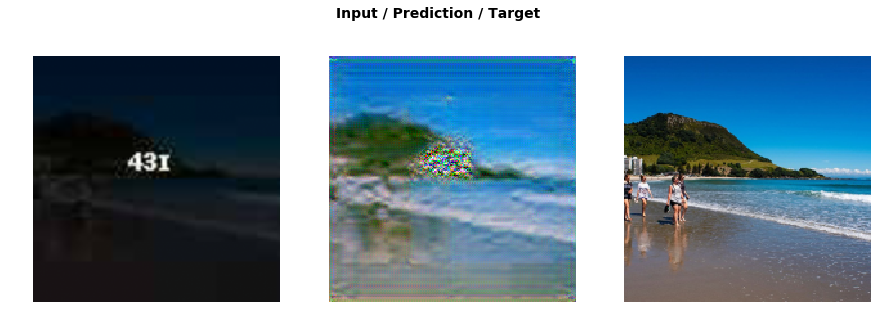

In [0]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

In [0]:
learn.destroy()
gc.collect();

this Learner object self-destroyed - it still exists, but no longer usable


In [0]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(820, 1024), have 6543MB of GPU RAM free


In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight, opt_func = raoptar)

In [0]:
learn.load('/content/train/low_res/models/3b');

In [0]:
learn.data = data_hr

In [0]:
torch.cuda.empty_cache()

In [0]:
gc.collect()

122

In [0]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

epoch,train_loss,valid_loss,time
0,0.374939,0.210284,12:59
1,0.108875,0.113063,12:40
2,0.065830,0.066140,12:38
3,0.051884,0.080506,12:37
4,0.049547,0.057463,12:35
5,0.043214,0.044299,12:34
6,0.047292,0.048972,12:35
7,0.043585,0.051908,12:33
8,0.043586,0.033640,12:33
9,0.014837,0.014612,12:33


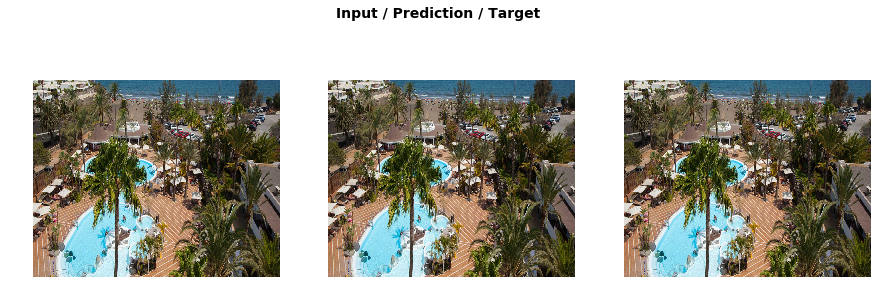

In [0]:
do_fit('4a', slice(6e-4,1e-4))

In [0]:
learn.load('/content/3a')

Learner(data=ImageDataBunch;

Train: LabelList (489 items)
x: ImageImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
Path: train/med_res;

Valid: LabelList (54 items)
x: ImageImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
Path: train/med_res;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64,

In [0]:
learn.unfreeze()

In [0]:
learn = None
gc.collect();

In [0]:
torch.cuda.empty_cache()


In [0]:
gc.collect()

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


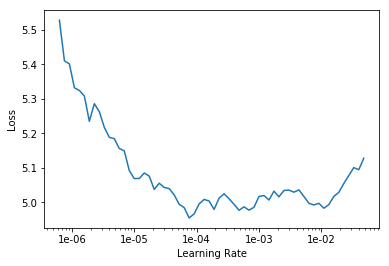

In [0]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.012326,0.014594,13:09
1,0.011933,0.014583,13:08
2,0.013097,0.014545,13:08
3,0.012067,0.014493,13:08
4,0.013262,0.014422,13:08
5,0.012133,0.014378,13:08
6,0.012839,0.014257,13:07
7,0.012540,0.014206,13:08
8,0.012812,0.014139,13:08
9,0.012932,0.014099,13:08


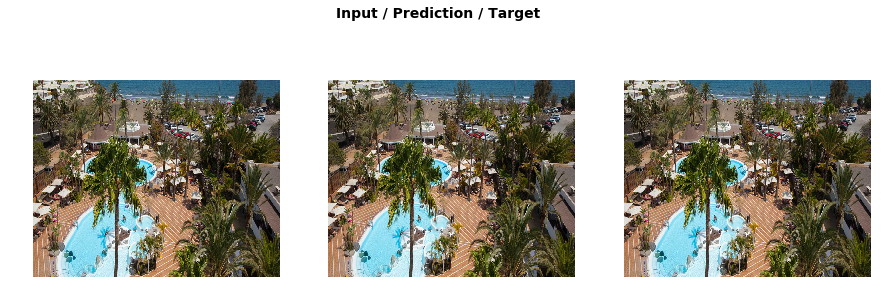

In [0]:
do_fit('4b',slice(1e-6,7e-4))

In [0]:
learn.freeze()

In [0]:
do_fit('4c',slice(1e-5,1e-3))

epoch,train_loss,valid_loss,time


KeyboardInterrupt: ignored

In [0]:
fn = data_mr.valid_ds.x.items[0]; fn

In [0]:
img = open_image(fn); img.shape

In [0]:
p,img_hr,b = learn.predict(img)

In [0]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [0]:
Image(img_hr).show(figsize=(18,15))